In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
#import wandb
#from wandb.integration.keras import WandbMetricsLogger

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)

In [11]:
#wandb.login()

In [12]:
#run = wandb.init(
#    dir = "../results/syntheticdata/",
#    project = "series_fixedfrequency_lstm"
#)

Planted motifs: 100
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900]


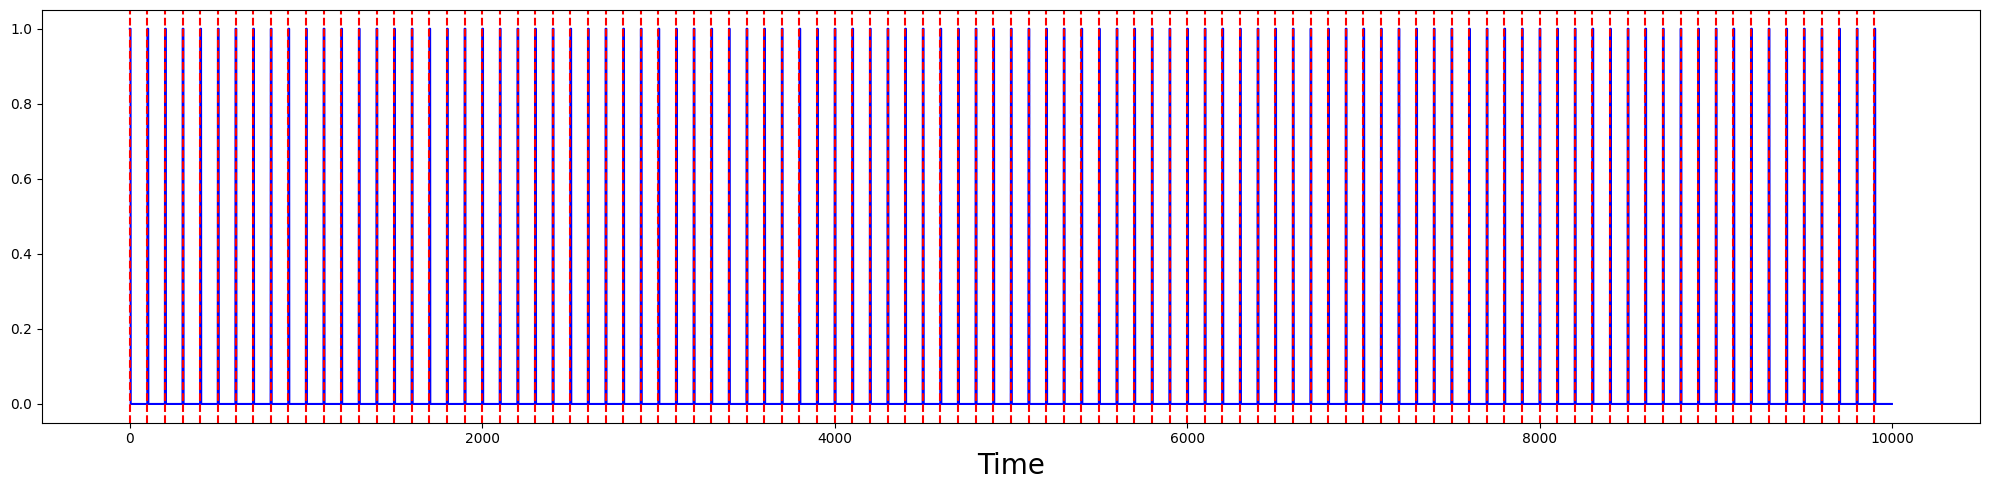

In [13]:
#fixed frequency repetitions
n = 10000
k = 1
variable_indexes = [0]
data_scenario_fixed_frequency = np.zeros(n)
#put the pattern every 1000 indexes
motif_indexes_scenario1 = []
motif_pattern = [1, 1, 1, 1, 1]
p = len(motif_pattern)
for i in range(0, n, 100):
    motif_indexes_scenario1.append(i)
    data_scenario_fixed_frequency[i:i+p] = 1

print("Planted motifs:", len(motif_indexes_scenario1))
print(motif_indexes_scenario1)

#save to file as csv
data_scenario_fixed_frequency = data_scenario_fixed_frequency.astype(int)
np.savetxt("../data/syntheticdata/scenario_fixed_frequency.csv", data_scenario_fixed_frequency, delimiter=",")
np.savetxt("../data/syntheticdata/motif_indexes_scenario_fixed_frequency.csv", motif_indexes_scenario1, delimiter=",")

#plot multivariate data using subplots in red the planted motifs
plt.figure(figsize=(20, 5))
plt.plot(data_scenario_fixed_frequency, color='blue')
for i in motif_indexes_scenario1:
    plt.axvline(x=i, color='red', linestyle='--')
plt.xlabel('Time', size=20)
plt.tight_layout()
plt.savefig("../images/data_scenario_fixed_frequency.pdf")
plt.show()


In [14]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data,variable_indexes, past_window, step, forward_window, motif_indexes):
    X1, X2, y = list(), list(),  list() # X1: data, X2: indexes of the motifs, y: distance to the next motif
    for idx in range(len(data[0]) - past_window - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + past_window
        forward_window__end = window_end_idx + forward_window

        #if doesnt exist more matches after the window
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        motif_indexes_in_window = [motif_idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forward_window = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forward_window__end]

        if motif_indexes_in_forward_window:
            next_match_in_forward_window = motif_indexes_in_forward_window[0]
        else:
            next_match_in_forward_window = -1  #no match in forward window but exist in the future

        data_window = data[variable_indexes,idx:window_end_idx]

        data_y = -1 
        if next_match_in_forward_window != -1:
            # index of the next match relative to the last match in the window
            #data_y = next_match_in_forward_window - motif_indexes_in_window[-1] 
            # index of the next match relative to the end of the window
            data_y = next_match_in_forward_window - window_end_idx
        
        X1.append(data_window)
        X2.append(motif_indexes_in_window) #TODO: doesnt seem to make sense to use absolute indexes
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2) , np.array(y)

In [15]:
#load data 
data_scenario_fixed_frequency = np.loadtxt("../data/syntheticdata/scenario_fixed_frequency.csv", delimiter=",")
data_scenario_fixed_frequency = data_scenario_fixed_frequency.astype(int)
data_scenario_fixed_frequency= data_scenario_fixed_frequency.reshape(1, -1)
motif_indexes_scenario_fixed_frequency = np.loadtxt("../data/syntheticdata/motif_indexes_scenario_fixed_frequency.csv", delimiter=",")
motif_indexes_scenario_fixed_frequency = motif_indexes_scenario_fixed_frequency.astype(int)


past_window = 2000 #window size
step = 5 #step size for the sliding window
forward_window = 200 #forward window size
#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2 , y  = create_dataset(data_scenario_fixed_frequency,variable_indexes=np.arange(1), past_window=past_window, step=step, forward_window=forward_window, motif_indexes=motif_indexes_scenario_fixed_frequency)
print(X1.shape, X2.shape, y.shape) # samples, features, time steps
print(X1[0,0], X2[0], y[0])

X1 = np.transpose(X1, (0, 2, 1)) #reshape input to be [samples, time steps, features]
print(X1.shape)

(1580, 1, 2000) (1580, 21) (1580,)
[1 1 1 ... 0 0 0] [   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000] 100
(1580, 2000, 1)


In [16]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [17]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

import keras_tuner as kt

class MyHyperModel_LSTM(kt.HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        units = hp.Int('units', min_value=10, max_value=100, step=10)
        model.add(LSTM(units=units, activation='tanh', return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model

In [18]:
import collections
from keras.callbacks import EarlyStopping
import pickle
from sklearn.preprocessing import MinMaxScaler



class CVTuner(kt.engine.tuner.Tuner):

    def __init__(self, *args, **kwargs):
        super(CVTuner, self).__init__(*args, **kwargs)
        # cols are metrics-val_loss, val_mae, val_rmse, val_r2
        self.metrics_history = []
        #if exists load metrics history
        if os.path.exists(os.path.join(self.project_dir, "metrics_history.npy")):
            self.metrics_history = np.load(os.path.join(self.project_dir, "metrics_history.npy"), allow_pickle=True)
        

    def run_trial(self, trial, x, y, *args, **kwargs):
        callbacks = kwargs.pop("callbacks", [])
        callbacks.append(EarlyStopping(patience=10, monitor="val_loss"))
        verbose = kwargs.pop("verbose", 0)
        batch_size = trial.hyperparameters.Choice('batch_size', values=[8,16,32,64])

        metrics = collections.defaultdict(list)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        trial_metrics = np.zeros((5, 4), dtype=np.float32)
        for i, (train_indices, test_indices) in enumerate(cv.split(x)):
            #split train indices into train and validation
            mid = int(0.8 * len(train_indices))
            train_indices, val_indices = train_indices[:mid], train_indices[mid:]
            X_train, X_val, X_test = x[train_indices], x[val_indices], x[test_indices]
            y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test) 
            metrics["test_loss"].append(test_loss)
            metrics["test_mae"].append(test_mae)
            metrics["test_rmse"].append(test_rmse)
            metrics["test_r2"].append(test_r2)
            #save metrics
            for j, (_, value) in enumerate(metrics.items()):
                trial_metrics[i, j] = value[-1]

        self.metrics_history.append(trial_metrics)
        print({name: np.mean(values) for name, values in metrics.items()})
        #save cross validation metrics
        return {name: np.mean(values) for name, values in metrics.items()}
    
    def save_metrics(self):
        # aggregate metric_history into a matrix (num trials, num folds, num metrics)
        fname = os.path.join(self.project_dir, "metrics_history.npy")
        np.save(fname, np.array(self.metrics_history))
    
    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)

tuner = CVTuner(
  hypermodel=MyHyperModel_LSTM(input_shape=(X1.shape[1], X1.shape[2])),
  oracle=kt.oracles.GridSearchOracle(
    objective=kt.Objective("test_loss", "min"),
    max_trials=None),
    directory='../results/syntheticdata',
    project_name='series_fixedfrequency_lstm')
    

tuner.search(
        x=X1,
        y=y,
        verbose=1,
        callbacks=[],
    )
#run.finish()
tuner.save_metrics()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
10                |10                |units
0.001             |0.001             |learning_rate



Epoch 1/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step - loss: 3602.3264 - mae: 52.6648 - r2_score: -3.3500 - root_mean_squared_error: 60.0152 - val_loss: 3919.9053 - val_mae: 56.2419 - val_r2_score: -4.1735 - val_root_mean_squared_error: 62.6091
Epoch 2/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 792ms/step - loss: 3523.6516 - mae: 51.9744 - r2_score: -3.2845 - root_mean_squared_error: 59.3560 - val_loss: 3917.2344 - val_mae: 56.2195 - val_r2_score: -4.1700 - val_root_mean_squared_error: 62.5878
Epoch 3/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 795ms/step - loss: 3675.7324 - mae: 53.5657 - r2_score: -3.5842 - root_mean_squared_error: 60.6071 - val_loss: 3914.3799 - val_mae: 56.1955 - val_r2_score: -4.1662 - val_root_mean_squared_error: 62.5650
Epoch 4/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - loss: 3568.6794 - mae: 52.1586 - r2_score: -3.2129 - root_mean_squared_error: 59.7357 - val_loss: 3911.2849 - val_mae: 56.1693 - val_r2_score: -4.1621 - val_root_mean_squared_error: 62.5403
Epoch 5/400
4/4 ━━━━━━━━━━━━

KeyboardInterrupt: 